In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import seaborn as sns
from tqdm.auto import tqdm

/scratch/work/lyub2/.conda_envs/lb-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import folium
from shapely.geometry import Point
from shapely.wkt import loads as wkt_loads
from shapely.geometry import shape
import branca.colormap as cm
from branca.colormap import LinearColormap

In [3]:
## pip install folium 
#已经安装好了

## P1A1 missing values -- areaid

### df_a1整合

In [3]:
# Initialize an empty DataFrame for the final result
df_a1 = pd.DataFrame(columns=['area_id', 'areaid_count', 'missing_counts', 'missing_percentage'])

# Define the path to the parent directory
parent_directory = '/scratch/work/lyub2/Problem_output_September/'

df_list = []

# Iterate through all 30 folders with tqdm for progress bar
for day in tqdm(range(1, 31), desc="Processing folders"):
    # Generate folder name in the format 'MMDD_output_csv' (e.g., '0901_output_csv')
    folder_name = f"09{str(day).zfill(2)}_output_csv"
    # Define the full path to the csv file
    file_path = os.path.join(parent_directory, folder_name, 'P1A1_missing_values_areaid.csv')
    
    # Check if the file exists to avoid errors
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        continue
    
    # Read the current CSV file
    df_current = pd.read_csv(file_path)
    
    # Drop the 'missing_info' column as it's not needed
    df_current = df_current.drop(columns=['missing_info'])
    
    # Append the current dataframe to the list
    df_list.append(df_current)

# Concatenate all dataframes in the list
df_a1 = pd.concat(df_list, ignore_index=True)

# Group by 'area_id' and sum the 'areaid_count' and 'missing_counts'
df_a1 = df_a1.groupby('area_id', as_index=False).agg({
    'areaid_count': 'sum',
    'missing_counts': 'sum'
})

# Calculate the missing percentage for each area_id
df_a1['missing_percentage'] = (df_a1['missing_counts'] / df_a1['areaid_count']) * 100


Processing folders: 100%|██████████| 30/30 [00:37<00:00,  1.26s/it]


In [4]:
# Display the final DataFrame
df_a1.to_csv("/scratch/work/lyub2/Problem_output_September/P1A1/P1A1.csv",index=False)

### 合并df_tc和geo map

In [3]:
gdf_map = gpd.read_file(r'/scratch/work/lyub2/HZR/ykr_250_15_kuntaa_grid_v2.geojson').to_crs('EPSG:4326')

gdf_map.to_file('/scratch/work/lyub2/HZR/geo_map.geojson', driver="GeoJSON")

In [ ]:
geo_df = gdf_map.merge(df_a1, left_on='id', right_on='area_id', how='left')

In [6]:
geo_df

,id,geometry,area_id,areaid_count,missing_counts,missing_percentage
0,4,"MULTIPOLYGON (((24.30521 60.00698, 24.30073 60...",4.0,8.0,6.0,75.000000
1,5,"MULTIPOLYGON (((24.30968 60.00708, 24.30521 60...",5.0,3.0,2.0,66.666667
2,6,"MULTIPOLYGON (((24.31416 60.00717, 24.30968 60...",6.0,6.0,0.0,0.000000
3,7,"MULTIPOLYGON (((24.31864 60.00726, 24.31416 60...",NaN,NaN,NaN,NaN
4,8,"MULTIPOLYGON (((24.32312 60.00735, 24.31864 60...",8.0,5.0,5.0,100.000000
...,...,...,...,...,...,...
75424,93612,"MULTIPOLYGON (((25.43944 60.67859, 25.43487 60...",93612.0,4.0,0.0,0.000000
75425,93613,"MULTIPOLYGON (((25.44402 60.67864, 25.43944 60...",NaN,NaN,NaN,NaN
75426,93614,"MULTIPOLYGON (((25.44859 60.67869, 25.44402 60...",93614.0,2.0,0.0,0.000000
75427,93615,"MULTIPOLYGON (((25.45317 60.67875, 25.44859 60...",93615.0,4.0,0.0,0.000000


### 保存geo_df 或者 打开geo_df

In [7]:
geo_df.to_csv("/scratch/work/lyub2/Problem_output_September/P1A1/geo_df.csv", index=False)

In [2]:
geo_df=pd.read_csv("/scratch/work/lyub2/Problem_output_September/P1A1/geo_df.csv")

### 从普通的pandas df 转为 geopandas df

In [6]:
from shapely.wkt import loads as wkt_loads

first_geom = geo_df['geometry'].iloc[0]
print(type(first_geom))

# Convert the geometry column if necessary
if isinstance(first_geom, str):
    geo_df['geometry'] = geo_df['geometry'].apply(wkt_loads)
elif isinstance(first_geom, dict):
    geo_df['geometry'] = geo_df['geometry'].apply(shape)

# Convert to a GeoDataFrame
geo_df = gpd.GeoDataFrame(geo_df, geometry='geometry', crs='EPSG:4326')

<class 'str'>


In [7]:
## 需要的话 检查一下类型
print(type(geo_df))
print(type(geo_df.geometry))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>


### 总图 和 五个组的分开图

In [ ]:
geo_df['centroid'] = geo_df.geometry.centroid

# Ensure centroids are Points and extract their coordinates
geo_df['coordinates'] = geo_df['centroid'].apply(lambda x: [x.y, x.x] if isinstance(x, Point) else None)

# Filter out any rows where the centroid could not be computed properly (i.e., coordinates are None)
geo_df = geo_df.dropna(subset=['coordinates'])

# Debugging: Print the first few rows
print(geo_df[['area_id', 'coordinates', 'missing_percentage']].head())

# Check the number of valid rows
print(f"Number of valid rows: {len(geo_df)}")

# Define the custom groups
bins = [0, 20, 40, 60, 80, 100]  # Define the intervals for the groups

# Assign colors to each group, from light to dark
colors = ['#1f77b4', '#ff7f0e', '#9467bd', '#e377c2', '#d62728']  # from lighter color to darker ones

# Initialize the map centered around Helsinki
m = folium.Map(location=[60.2, 24.9], zoom_start=10)

# Function to assign color based on the group
def get_color(missing_percentage):
    for i in range(len(bins) - 1):
        if bins[i] < missing_percentage <= bins[i + 1]:
            return colors[i]
    return colors[-1]  # Default to the last color if out of bounds

# Add each area to the map with a dynamic color based on the group of missing_percentage
for idx, row in geo_df.iterrows():
    folium.CircleMarker(
        location=row['coordinates'],
        radius=0.2,  # Adjusted radius for visibility
        color=get_color(row['missing_percentage']),
        fill=True,
        fill_opacity=0.7,
        popup=f"Area ID: {row['area_id']}<br>Missing Percentage: {row['missing_percentage']:.2f}%"
    ).add_to(m)

# Create a legend manually using a color map with text annotations
legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 150px; height: 150px;
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;">
&emsp;<b>Legend</b><br>
&emsp;<i style="background:#1f77b4;color:#1f77b4">.....</i> 0-20%<br>
&emsp;<i style="background:#2ca02c;color:#2ca02c">.....</i> 21-40%<br>
&emsp;<i style="background:#ff7f0e;color:#ff7f0e">.....</i> 41-60%<br>
&emsp;<i style="background:#9467bd;color:#9467bd">.....</i> 61-80%<br>
&emsp;<i style="background:#d62728;color:#d62728">.....</i> 81-100%<br>
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))

# Save or display the map
m.save('/scratch/work/lyub2/Problem_output_September/P1A1/missing_percentage_map.html')
m

In [10]:
geo_df['centroid'] = geo_df.geometry.centroid

# Ensure centroids are Points and extract their coordinates
geo_df['coordinates'] = geo_df['centroid'].apply(lambda x: [x.y, x.x] if isinstance(x, Point) else None)

# Filter out any rows where the centroid could not be computed properly (i.e., coordinates are None)
geo_df = geo_df.dropna(subset=['coordinates'])

# Define the custom groups
bins = [0, 20, 40, 60, 80, 100]  # Define the intervals for the groups

# Assign distinct colors to each group, avoiding green and yellow
colors = ['#1f77b4', '#ff7f0e', '#9467bd', '#e377c2', '#d62728']  # Distinct colors without green/yellow

# Prepare a dictionary for mapping bins to colors
group_mapping = {
    '0-20%': {'bin': (0, 20), 'color': '#1f77b4'},
    '21-40%': {'bin': (20, 40), 'color': '#ff7f0e'},
    '41-60%': {'bin': (40, 60), 'color': '#9467bd'},
    '61-80%': {'bin': (60, 80), 'color': '#e377c2'},
    '81-100%': {'bin': (80, 100), 'color': '#d62728'}
}

# Debugging: Print the first few rows
print(geo_df[['area_id', 'coordinates', 'missing_percentage']].head())

# Check the number of valid rows
print(f"Number of valid rows: {len(geo_df)}")

/tmp/ipykernel_169290/1137339467.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_df['centroid'] = geo_df.geometry.centroid


   area_id                              coordinates  missing_percentage
0      4.0  [60.00805922805692, 24.302875155805474]           75.000000
1      5.0  [60.008150640226056, 24.30735337174473]           66.666667
2      6.0  [60.008241900685185, 24.31183161650042]            0.000000
3      NaN   [60.00833300943239, 24.31630989002495]                 NaN
4      8.0     [60.0084239664657, 24.3207881922707]          100.000000
Number of valid rows: 75429


In [ ]:
group1_df = geo_df[(geo_df['missing_percentage'] > 0) & (geo_df['missing_percentage'] <= 20)]

# Initialize a map centered around Finland or Helsinki
m1 = folium.Map(location=[64.0, 26.0], zoom_start=6)

# Add each area in Group 1 to the map
for idx, row in group1_df.iterrows():
    folium.CircleMarker(
        location=row['coordinates'],
        radius=0.2,  # Adjusted radius for visibility
        color='#1f77b4',
        fill=True,
        fill_opacity=0.7,
        popup=f"Area ID: {row['area_id']}<br>Missing Percentage: {row['missing_percentage']:.2f}%"
    ).add_to(m1)

legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 150px; height: auto;
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;">
&emsp;<b>Legend</b><br>
&emsp;<i style="background:#1f77b4;color:#1f77b4">.....</i> 0-20%<br>
</div>
'''

m1.get_root().html.add_child(folium.Element(legend_html))
# Save or display the map for Group 1
m1.save('/scratch/work/lyub2/Problem_output_September/P1A1/[0-20]_missing_percentage_map.html')
m1

In [8]:
group1_df = geo_df[(geo_df['missing_percentage'] > 0) & (geo_df['missing_percentage'] <= 20)]
group1_df.head()

,id,geometry,area_id,areaid_count,missing_counts,missing_percentage
5,9,"MULTIPOLYGON (((24.3276 60.00744, 24.32312 60....",9.0,25.0,3.0,12.000000
26,30,"MULTIPOLYGON (((24.42164 60.00931, 24.41717 60...",30.0,35.0,4.0,11.428571
29,33,"MULTIPOLYGON (((24.43508 60.00957, 24.4306 60....",33.0,117.0,7.0,5.982906
30,34,"MULTIPOLYGON (((24.43956 60.00966, 24.43508 60...",34.0,49.0,2.0,4.081633
31,35,"MULTIPOLYGON (((24.44404 60.00974, 24.43956 60...",35.0,26.0,3.0,11.538462


In [9]:
type(group1_df)

geopandas.geodataframe.GeoDataFrame

In [10]:
group1_df.set_crs(epsg=4326, inplace=True)  # WGS84 is commonly used for lat/lon data

# Save to GeoJSON file
group1_df.to_file('/scratch/work/lyub2/Problem_output_September/P1A1/gdf_G1.geojson', driver='GeoJSON')

/scratch/work/lyub2/.conda_envs/lb-env/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
group2_df = geo_df[(geo_df['missing_percentage'] > 20) & (geo_df['missing_percentage'] <= 40)]

# Initialize a map centered around Finland or Helsinki
m2 = folium.Map(location=[64.0, 26.0], zoom_start=6)

# Add each area in Group 2 to the map
for idx, row in group2_df.iterrows():
    folium.CircleMarker(
        location=row['coordinates'],
        radius=1.5,  # Adjusted radius for visibility
        color='#ff7f0e',
        fill=True,
        fill_opacity=0.7,
        popup=f"Area ID: {row['area_id']}<br>Missing Percentage: {row['missing_percentage']:.2f}%"
    ).add_to(m2)

legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 150px; height: auto;
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;">
&emsp;<b>Legend</b><br>
&emsp;<i style="background:#ff7f0e;color:#ff7f0e">.....</i> 20-40%<br>
</div>
'''

m2.get_root().html.add_child(folium.Element(legend_html))
# Save or display the map for Group 2
m2.save('/scratch/work/lyub2/Problem_output_September/P1A1/(20-40]_missing_percentage_map.html')
m2

In [11]:
group2_df = geo_df[(geo_df['missing_percentage'] > 20) & (geo_df['missing_percentage'] <= 40)]
print(type(group2_df))

group2_df.set_crs(epsg=4326, inplace=True)  # WGS84 is commonly used for lat/lon data

# Save to GeoJSON file
group2_df.to_file('/scratch/work/lyub2/Problem_output_September/P1A1/gdf_G2.geojson', driver='GeoJSON')

<class 'geopandas.geodataframe.GeoDataFrame'>


/scratch/work/lyub2/.conda_envs/lb-env/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
group3_df = geo_df[(geo_df['missing_percentage'] > 40) & (geo_df['missing_percentage'] <= 60)]

# Initialize a map centered around Finland or Helsinki
m3 = folium.Map(location=[64.0, 26.0], zoom_start=6)

# Add each area in Group 3 to the map
for idx, row in group3_df.iterrows():
    folium.CircleMarker(
        location=row['coordinates'],
        radius=1.5,  # Adjusted radius for visibility
        color='#9467bd',
        fill=True,
        fill_opacity=0.7,
        popup=f"Area ID: {row['area_id']}<br>Missing Percentage: {row['missing_percentage']:.2f}%"
    ).add_to(m3)

legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 150px; height: auto;
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;">
&emsp;<b>Legend</b><br>
&emsp;<i style="background:#9467bd;color:#9467bd">.....</i> 40-60%<br>
</div>
'''

m3.get_root().html.add_child(folium.Element(legend_html))
# Save or display the map for Group 1
m3.save('/scratch/work/lyub2/Problem_output_September/P1A1/(40-60]_missing_percentage_map.html')
m3

In [12]:
group3_df = geo_df[(geo_df['missing_percentage'] > 40) & (geo_df['missing_percentage'] <= 60)]
print(type(group3_df))

group3_df.set_crs(epsg=4326, inplace=True)  # WGS84 is commonly used for lat/lon data

# Save to GeoJSON file
group3_df.to_file('/scratch/work/lyub2/Problem_output_September/P1A1/gdf_G3.geojson', driver='GeoJSON')

<class 'geopandas.geodataframe.GeoDataFrame'>


/scratch/work/lyub2/.conda_envs/lb-env/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
group4_df = geo_df[(geo_df['missing_percentage'] > 60) & (geo_df['missing_percentage'] <= 80)]

# Initialize a map centered around Finland or Helsinki
m4 = folium.Map(location=[64.0, 26.0], zoom_start=6)

# Add each area in Group 4 to the map
for idx, row in group4_df.iterrows():
    folium.CircleMarker(
        location=row['coordinates'],
        radius=1.5,  # Adjusted radius for visibility
        color='#e377c2',
        fill=True,
        fill_opacity=0.7,
        popup=f"Area ID: {row['area_id']}<br>Missing Percentage: {row['missing_percentage']:.2f}%"
    ).add_to(m4)

legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 150px; height: auto;
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;">
&emsp;<b>Legend</b><br>
&emsp;<i style="background:#e377c2;color:#e377c2">.....</i> 60-80%<br>
</div>
'''

m4.get_root().html.add_child(folium.Element(legend_html))
# Save or display the map for Group 1
m4.save('/scratch/work/lyub2/Problem_output_September/P1A1/(60-80]_missing_percentage_map.html')
m4

In [13]:
group4_df = geo_df[(geo_df['missing_percentage'] > 60) & (geo_df['missing_percentage'] <= 80)]
print(type(group4_df))

group4_df.set_crs(epsg=4326, inplace=True)  # WGS84 is commonly used for lat/lon data

# Save to GeoJSON file
group4_df.to_file('/scratch/work/lyub2/Problem_output_September/P1A1/gdf_G4.geojson', driver='GeoJSON')

<class 'geopandas.geodataframe.GeoDataFrame'>


/scratch/work/lyub2/.conda_envs/lb-env/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
group5_df = geo_df[(geo_df['missing_percentage'] > 80) & (geo_df['missing_percentage'] <= 100)]

# Initialize a map centered around Finland or Helsinki
m5 = folium.Map(location=[64.0, 26.0], zoom_start=6)

# Add each area in Group 5 to the map
for idx, row in group5_df.iterrows():
    folium.CircleMarker(
        location=row['coordinates'],
        radius=1.5,  # Adjusted radius for visibility
        color='#d62728',
        fill=True,
        fill_opacity=0.7,
        popup=f"Area ID: {row['area_id']}<br>Missing Percentage: {row['missing_percentage']:.2f}%"
    ).add_to(m5)

legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 150px; height: auto;
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;">
&emsp;<b>Legend</b><br>
&emsp;<i style="background:#d62728;color:#d62728">.....</i> 80-100%<br>
</div>
'''

m5.get_root().html.add_child(folium.Element(legend_html))
# Save or display the map for Group 1
m5.save('/scratch/work/lyub2/Problem_output_September/P1A1/(80-100]_missing_percentage_map.html')
m5

In [14]:
group5_df = geo_df[(geo_df['missing_percentage'] > 80) & (geo_df['missing_percentage'] <= 100)]
print(type(group5_df))

group5_df.set_crs(epsg=4326, inplace=True)  # WGS84 is commonly used for lat/lon data

# Save to GeoJSON file
group5_df.to_file('/scratch/work/lyub2/Problem_output_September/P1A1/gdf_G5.geojson', driver='GeoJSON')

<class 'geopandas.geodataframe.GeoDataFrame'>


/scratch/work/lyub2/.conda_envs/lb-env/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### missing percentage的比例分布

In [9]:

group_labels = ['G1 0-20%', 'G2 20-40%', 'G3 40-60%', 'G4 60-80%', 'G5 80-100%']
bins = [0, 20, 40, 60, 80, 100]

# Add a new column to categorize the missing_percentage into groups
geo_df['group'] = pd.cut(geo_df['missing_percentage'], bins=bins, labels=group_labels, include_lowest=True, right=True)

# Calculate counts and percentages
group_counts = geo_df['group'].value_counts(sort=False)
group_percentages = (group_counts / len(geo_df)) * 100

# Display the results
print("Counts by Group:")
print(group_counts)
print("\nPercentages by Group:")
print(group_percentages)


Counts by Group:
group
G1 0-20%      30127
G2 20-40%     11635
G3 40-60%      5447
G4 60-80%      2889
G5 80-100%    11199
Name: count, dtype: int64

Percentages by Group:
group
G1 0-20%      39.940872
G2 20-40%     15.425102
G3 40-60%      7.221360
G4 60-80%      3.830092
G5 80-100%    14.847075
Name: count, dtype: float64


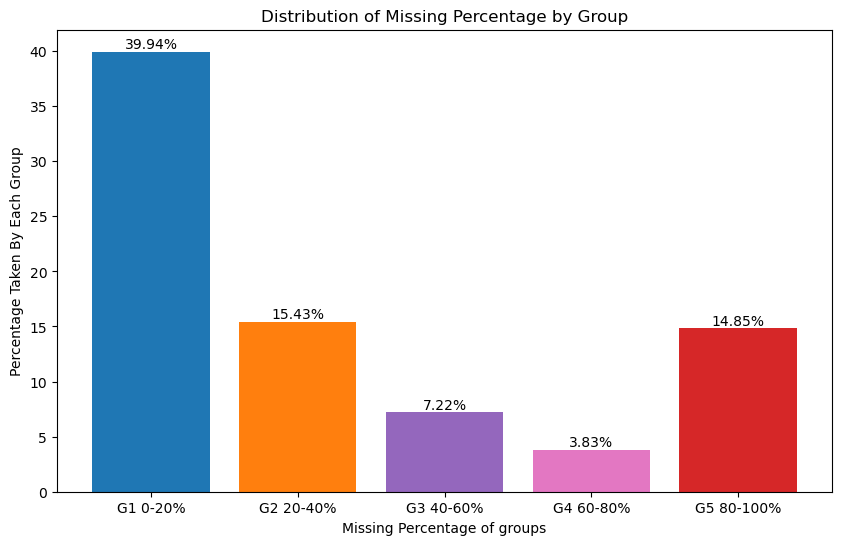

In [10]:
# Define colors corresponding to the groups (same as in the Folium maps)
colors = ['#1f77b4', '#ff7f0e', '#9467bd', '#e377c2', '#d62728']

plt.figure(figsize=(10, 6))
bars = plt.bar(group_labels, group_percentages, color=colors)

# Annotate each bar with its corresponding percentage
for bar, percentage in zip(bars, group_percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{percentage:.2f}%', ha='center', va='bottom')

# Alternatively, create a bar plot for the percentages

plt.title('Distribution of Missing Percentage by Group')
plt.xlabel('Missing Percentage of groups')
plt.ylabel('Percentage Taken By Each Group')
plt.show()
